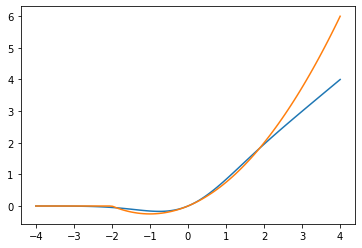

In [23]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F


x = torch.linspace(-4, 4, 100)
y = F.gelu(x)
z = x * F.relu(x + 2) / 4
# z = x * F.relu6(x + 3) / 6
# z = (x * F.relu(x) - 0.5) / 3


def relu2(x):
    # `a` is the bias from the previous layer
    a, b, c, d = 2, 1, 0.25, 0.25
    return c * (F.relu(x + a) - b) ** 2 - d

z = relu2(x)

plt.plot(x, y, label="gelu")
plt.plot(x, z, label="srelu")
plt.show()



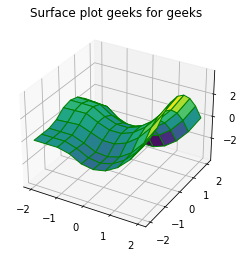

In [24]:
import numpy as np
import matplotlib.pyplot as plt
 
def relu(x):
    return np.maximum(0, x)


def relu2(x):
    # `a` is the bias from the previous layer
    a, b, c, d = 1, 1, 1, 0
    return c * (np.maximum(0, x + a) - b) ** 2 - d


# defining surface and axes
x = np.outer(np.linspace(-2, 2, 10), np.ones(10))
y = x.copy().T

# 1-order cannot express
z = (x - y) * relu(x + y)
# z = x ** 2 - y ** 2

# both can express
# z = (x) * (x)
# z = relu(x) + relu(-x)

# 2-order cannot express
# z = (x + y + 2) * (relu(x + y + 2))
# z = (x + y + 3) * (x + y + 3)
# z = relu(x) + relu(y)
# z = relu(x) ** 2 + relu(y) ** 2

z = relu2(x + .1 * y) - relu2(y + .1 * x)
# z = relu(x) - relu(y)

fig = plt.figure()

# syntax for 3-D plotting
ax = plt.axes(projection ='3d')

# syntax for plotting
ax.plot_surface(x, y, z, cmap ='viridis', edgecolor ='green')
ax.set_title('Surface plot geeks for geeks')
plt.show()

In [172]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class OversizeConv2d(nn.Module):
    def __init__(self, dim, kernel_size, bias=False, interpolate=False):
        super().__init__()

        if interpolate is True:
            padding = 0
        elif interpolate is False or interpolate is None:
            assert kernel_size % 2 == 1
            padding = kernel_size // 2
        else:
            print(interpolate)
            assert interpolate % 2 == 1
            padding = interpolate // 2
            interpolate = to_2tuple(interpolate)

        self.conv_h = nn.Conv2d(
            dim, dim, (kernel_size, 1), padding=(padding, 0), groups=dim, bias=bias
        )
        self.conv_w = nn.Conv2d(
            dim, dim, (1, kernel_size), padding=(0, padding), groups=dim, bias=bias
        )

        self.dim = dim
        self.kernel_size = kernel_size
        self.interpolate = interpolate
        self.padding = padding

    def get_instance_kernel(self, instance_kernel_size):
        h_weight = F.interpolate(
            self.conv_h.weight,
            [instance_kernel_size[0], 1],
            mode="bilinear",
            align_corners=True,
        )
        w_weight = F.interpolate(
            self.conv_w.weight,
            [1, instance_kernel_size[1]],
            mode="bilinear",
            align_corners=True,
        )
        return h_weight, w_weight

    def forward(self, x):
        if self.interpolate is True:
            H, W = x.shape[-2:]
            instance_kernel_size = 2 * H - 1, 2 * W - 1
            h_weight, w_weight = self.get_instance_kernel(instance_kernel_size)

            padding = H - 1, W - 1
            x = F.conv2d(
                x, h_weight, self.conv_h.bias, padding=(padding[0], 0), groups=self.dim
            )
            x = F.conv2d(
                x, w_weight, self.conv_w.bias, padding=(0, padding[1]), groups=self.dim
            )
        elif isinstance(self.interpolate, tuple):
            h_weight, w_weight = self.get_instance_kernel(self.interpolate)
            x = F.conv2d(
                x,
                h_weight,
                self.conv_h.bias,
                padding=(self.padding, 0),
                groups=self.dim,
            )
            x = F.conv2d(
                x,
                w_weight,
                self.conv_w.bias,
                padding=(0, self.padding),
                groups=self.dim,
            )
        else:
            y = self.conv_h(x)
            y = self.conv_w(y)
            h_weight = F.unfold(
                self.conv_h.weight, ((self.kernel_size + 1) // 2, 1),
            ).flip(-2)
            w_weight = F.unfold(
                self.conv_w.weight, (1, (self.kernel_size + 1) // 2),
            ).flip(-2)
            x = torch.matmul(h_weight, x)
            x = torch.matmul(w_weight, x.transpose(-2, -1)).transpose(-2, -1)
            assert torch.allclose(x, y)
        return x

    def extra_repr(self):
        return f"dim={self.dim}, kernel_size={self.kernel_size}"


net = OversizeConv2d(3, 111).eval()
x = torch.rand(1, 3, 56, 56)
net(x)

AssertionError: 